# Rainfall-runoff experiment

In this experiment, we'll try to learn model for simple artificial dataset of simulated rainfall-runoff scenario.

The task is to forecast runoff (prutok) based on rainfall during time. We can test longer dependencies through time and power of LSTM networks.

In [2]:
%tensorflow_version 2.x
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import random

from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, SimpleRNN
from tensorflow import keras
import tensorflow as tf

from tqdm.notebook import tqdm

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


First, we need a dataset. Here's a code that simulates one river scenario.

There are two methods: `get_precip` for rainfall and `gen_discharge` for runoff. Runoff is lagged in time based on topography of the river (see `BASINS = [BASIN(area, lag)]` array)

In [3]:
MIN_EVENT_TIME = 5
MAX_EVENT_TIME = 20
MIN_EVENT_POWER = 0.05
MAX_EVENT_POWER = 0.5

BASINS = np.array([
    (1, 5),
    (2, 20),
    (2, 30),
    (1, 35),
    (3, 41),
    (2, 45),
    (1, 54),
    (2, 65),
    (1, 75),
])

def generate_precipitation(num_samples, events_ratio):  
    
    result = np.zeros(num_samples)
    num_events = int(events_ratio * num_samples)
    
    for event_start in random.sample(range(num_samples - MAX_EVENT_TIME), num_events):
        event = np.zeros((num_samples,))
        event_time = random.randint(MIN_EVENT_TIME, MAX_EVENT_TIME)
        event_power = random.random() * (MAX_EVENT_POWER - MIN_EVENT_POWER) + MIN_EVENT_POWER
        event[event_start: event_start + event_time] = (np.cos(np.linspace(-np.pi, np.pi, num=event_time)) * 0.5 + 0.5) * event_power
        result += event
    
    return result

def generate_discharge(basins, precip, runoff):            

    volumes = np.zeros((len(basins),len(precip)))
    discharges = np.zeros((len(basins),len(precip)))
    for i, p in enumerate(precip):      
        discharges[:,i] = volumes[:,i-1] * runoff
        volumes[:,i] = basins[:,0] * p + volumes[:,i-1] * (1 -runoff)        
    
    
    sum_discharge = np.zeros(len(precip))
    for d, basin in zip(discharges, basins):        
        lag = int(basin[1])
        lagged = np.roll(d, lag)
        lagged[:lag] = 0.0
        sum_discharge += lagged    
        
    return sum_discharge

Let's see how our simulated river behaves:

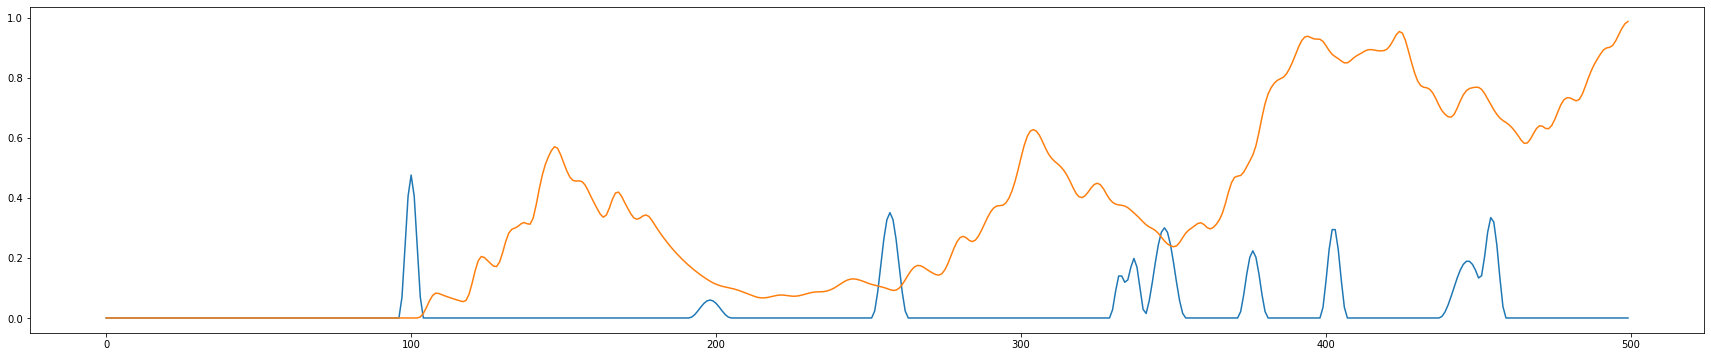

In [4]:
precip = generate_precipitation(500, 0.02)
discharge = generate_discharge(BASINS, precip, 0.05)

plt.figure(figsize=(30,6))
plt.plot(precip)
plt.plot(discharge)
plt.show()

We can generate some training examples for this river and try fit a neural network model to see if the model can learn the river hidden behavior.

In [5]:
import random

NUM_SAMPLES = 2000
SEQ_LEN = 500

raw_train_X = [generate_precipitation(SEQ_LEN, 0.02) for i in tqdm(range(NUM_SAMPLES))]
raw_train_Y = [generate_discharge(BASINS, precip_sample, 0.05) for precip_sample in tqdm(raw_train_X)]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

## Feed-forward network

In [6]:
inputs = Input(shape=(SEQ_LEN,))
x = Dense(200, activation='tanh')(inputs)
x = Dense(200, activation='tanh')(x)
x = Dense(200, activation='tanh')(x)
outputs = Dense(SEQ_LEN, activation='relu')(x)

fnn_model = Model(inputs, outputs)
fnn_model.compile(optimizer='adam', loss='mse')
fnn_model.summary()

fnn_train_X = np.vstack(raw_train_X)
fnn_train_Y = np.vstack(raw_train_Y)

print("Input shape:", fnn_train_X.shape)
print("Target shape:", fnn_train_Y.shape)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 500)]             0         
                                                                 
 dense (Dense)               (None, 200)               100200    
                                                                 
 dense_1 (Dense)             (None, 200)               40200     
                                                                 
 dense_2 (Dense)             (None, 200)               40200     
                                                                 
 dense_3 (Dense)             (None, 500)               100500    
                                                                 
Total params: 281,100
Trainable params: 281,100
Non-trainable params: 0
_________________________________________________________________
Input shape: (2000, 500)
Target shape: (2000, 500)


In [7]:
progress = fnn_model.fit(fnn_train_X, fnn_train_Y, validation_split=0.1, epochs=25)

Epoch 1/25
57/57 [==============================] - 6s 6ms/step - loss: 0.1174 - val_loss: 0.0243
Epoch 2/25
57/57 [==============================] - 0s 3ms/step - loss: 0.0140 - val_loss: 0.0082
Epoch 3/25
57/57 [==============================] - 0s 4ms/step - loss: 0.0068 - val_loss: 0.0055
Epoch 4/25
57/57 [==============================] - 0s 4ms/step - loss: 0.0049 - val_loss: 0.0050
Epoch 5/25
57/57 [==============================] - 0s 4ms/step - loss: 0.0043 - val_loss: 0.0036
Epoch 6/25
57/57 [==============================] - 0s 8ms/step - loss: 0.0035 - val_loss: 0.0032
Epoch 7/25
57/57 [==============================] - 0s 5ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 8/25
57/57 [==============================] - 0s 4ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 9/25
57/57 [==============================] - 0s 4ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 10/25
57/57 [==============================] - 0s 9ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 11/25
57/57 [

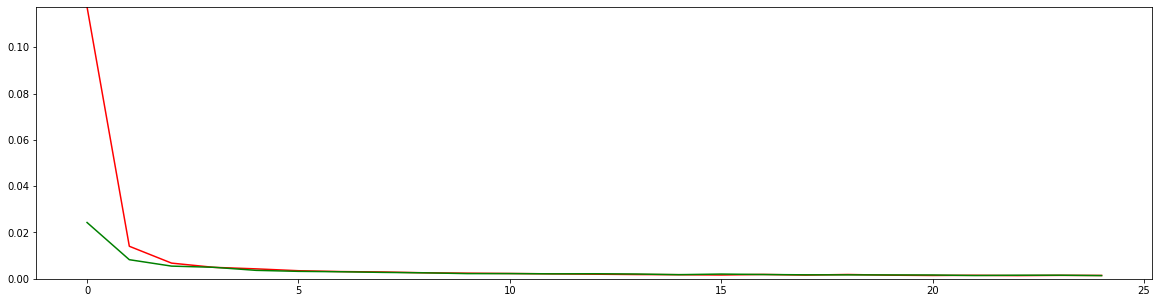

In [8]:
loss_history = np.array(progress.history['loss'])
val_loss_history = np.array(progress.history['val_loss'])
                            
plt.figure(figsize=(20,5))
plt.ylim(ymin=0, ymax=max(np.max(loss_history), np.max(val_loss_history)))
plt.plot(loss_history, 'r-')
plt.plot(val_loss_history, 'g-')
plt.show()

1/1 [==============================] - 0s 82ms/step


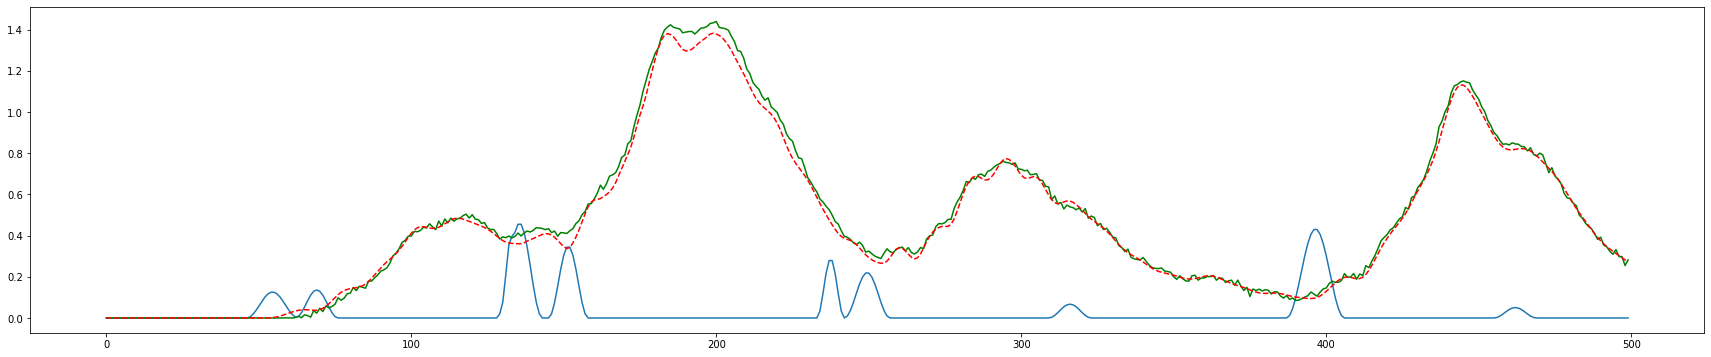

In [9]:
TEST_SEQ_LEN = 500
test_input = generate_precipitation(TEST_SEQ_LEN, 0.02)
test_output = generate_discharge(BASINS, test_input, 0.05)

prediction = fnn_model.predict(test_input.reshape(1, SEQ_LEN))[0]

plt.figure(figsize=(30,6))
plt.plot(test_input)
plt.plot(prediction, 'green')
plt.plot(test_output, 'r--')
plt.show()

## Recurrent network

In [10]:
inputs = Input(shape=(None, 1))
x = LSTM(64, return_sequences=True)(inputs)
outputs = Dense(1, activation='relu')(x)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='mse')
model.summary()

train_X = np.vstack(raw_train_X)
train_Y = np.vstack(raw_train_Y)

print("Input shape:", train_X.shape)
print("Target shape:", train_Y.shape)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, 1)]         0         
                                                                 
 lstm (LSTM)                 (None, None, 64)          16896     
                                                                 
 dense_4 (Dense)             (None, None, 1)           65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________
Input shape: (2000, 500)
Target shape: (2000, 500)


In [11]:
progress = model.fit(train_X, train_Y, validation_split=0.1, epochs=15)

Epoch 1/15
57/57 [==============================] - 5s 28ms/step - loss: 0.1771 - val_loss: 0.1764
Epoch 2/15
57/57 [==============================] - 1s 17ms/step - loss: 0.1013 - val_loss: 0.0194
Epoch 3/15
57/57 [==============================] - 1s 17ms/step - loss: 0.0134 - val_loss: 0.0093
Epoch 4/15
57/57 [==============================] - 1s 17ms/step - loss: 0.0089 - val_loss: 0.0065
Epoch 5/15
57/57 [==============================] - 1s 17ms/step - loss: 0.0060 - val_loss: 0.0050
Epoch 6/15
57/57 [==============================] - 1s 22ms/step - loss: 0.0058 - val_loss: 0.0055
Epoch 7/15
57/57 [==============================] - 1s 22ms/step - loss: 0.0038 - val_loss: 0.0027
Epoch 8/15
57/57 [==============================] - 1s 17ms/step - loss: 0.0028 - val_loss: 0.0023
Epoch 9/15
57/57 [==============================] - 1s 17ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 10/15
57/57 [==============================] - 1s 17ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 11/

In [12]:
model.save_weights("rr_lstm.npy")

In [13]:
TEST_SEQ_LEN = 2000
test_input = generate_precipitation(TEST_SEQ_LEN, 0.02)
test_output = generate_discharge(BASINS, test_input, 0.05)

In [14]:
prediction = model.predict(test_input.reshape((1, TEST_SEQ_LEN, 1)))[0]

1/1 [==============================] - 0s 347ms/step


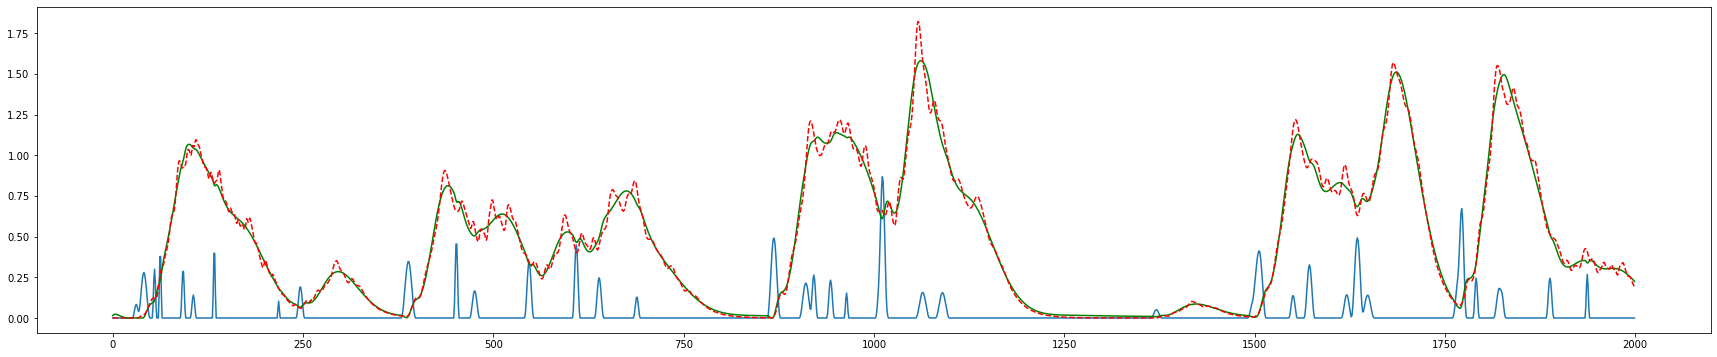

In [15]:
plt.figure(figsize=(30,6))
plt.plot(test_input)
plt.plot(prediction, 'green')
plt.plot(test_output, 'r--')
plt.show()

## Continuous prediction with LSTM network
LSTM can be used for daily prediction inslead of prediction on the full input.

We are **not** going to compile the model. 
We do not need training and inference will be much faster without gradient tracking turned off.

In [22]:
inputs = Input(batch_shape=(1, 1, 1))
x = LSTM(64, return_sequences=True, recurrent_activation='sigmoid', stateful=True)(inputs)
outputs = Dense(1, activation='linear')(x)
c_model = Model(inputs, outputs)
# c_model.compile(optimizer='adam', loss='mse')
c_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(1, 1, 1)]               0         
                                                                 
 lstm_1 (LSTM)               (1, 1, 64)                16896     
                                                                 
 dense_9 (Dense)             (1, 1, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


We are using the **same LSTM model instance** as above! Only sequence length is different.

In [23]:
c_model.load_weights("rr_lstm.npy")

First, the model is filled with the context from history

In [24]:
START_OFFSET = 150
HISTORY_LEN = 500
PREDICTION_LEN = len(test_input) - HISTORY_LEN - START_OFFSET

c_prediction = START_OFFSET * [0]
c_model.reset_states()

for i in tqdm(range(HISTORY_LEN)):
    single_pred = c_model.predict(test_input[i + START_OFFSET].reshape(1, 1, 1))[0][0][0]
    c_prediction.append(single_pred)

  0%|          | 0/500 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


Next, the model predicts output day by day

In [25]:
for i in tqdm(range(PREDICTION_LEN)):
    daily_measure = test_input[START_OFFSET + HISTORY_LEN + i].reshape(1, 1, 1)
    single_pred = c_model.predict(daily_measure)[0][0][0]
    c_prediction.append(single_pred)

  0%|          | 0/1350 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


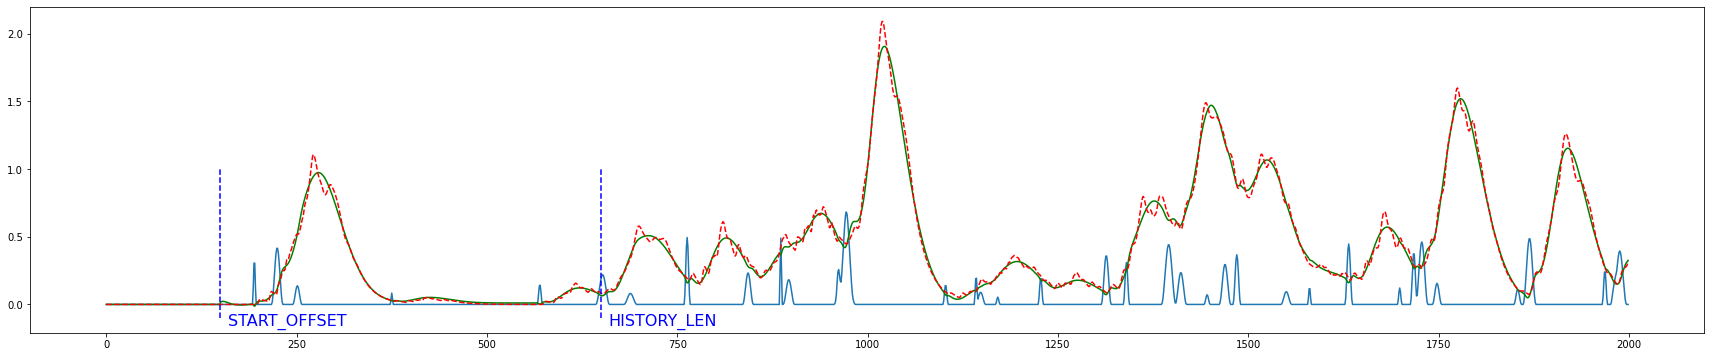

In [26]:
plt.figure(figsize=(30,6))
plt.plot(test_input)
plt.plot(c_prediction, 'green')
plt.plot(test_output, 'r--')
plt.plot([START_OFFSET, START_OFFSET], [-0.1, 1.0], 'b--')
plt.text(START_OFFSET + 10, -0.15, "START_OFFSET", c='b', size="16")
plt.plot([START_OFFSET + HISTORY_LEN, START_OFFSET + HISTORY_LEN], [-0.1, 1.0], 'b--')
plt.text(START_OFFSET + HISTORY_LEN + 10, -0.15, "HISTORY_LEN", c='b', size="16")
plt.show()